# Developing a Model

First, install the required R packages if not done already. See [Installing Required R Packages.](../00_Installing_Required_R_Packages.ipynb)

This notebook is a continuation meant to be viewed after the Data Exploration and Data Pre-Processing notebooks. In this notebook we will develop and assess various models and address some of the issues we've identified in our data exploration for model development.

## Loading Libraries

In the next section we will load the necessary libraries and dataset that will be used throughout this project.

In [2]:
library(glmnet)
library(dplyr)
library(xgboost)
library(pROC)

Loading required package: Matrix

Loaded glmnet 4.1-10


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [3]:
# Imports the dataset

train_final <- read.csv("../../data/output/customer_churn_ml_train_final.csv")
test_final <- read.csv("../../data/output/customer_churn_ml_test_final.csv")

In [4]:
# Changes column names of ID and LostCustomer variables
colnames(train_final)[1]<- "ID"
colnames(test_final)[1]<- "ID"
colnames(train_final)[2]<- "LostCustomer"
colnames(test_final)[2]<- "LostCustomer"

In [5]:
# Separate the target and input variable names
target <- "LostCustomer"
inputs <- setdiff(names(train_final), c(target, "ID"))

target
inputs

[1] "LostCustomer"

[1] "regionPctCustomers"          "numOfTotalReturns"          
 [3] "wksSinceLastPurch"           "basktPurchCount12Month"     
 [5] "intAdExposureCount12"        "intAdExposureCount36"       
 [7] "socialMediaAdCount12"        "socialMediaAdCount36"       
 [9] "socialMediaAdCountAll"       "totalNumProdPurchased"      
[11] "custInitiatedContacts"       "wksSinceFirstPurch"         
[13] "EstimatedIncome"             "regionMedHomeVal"           
[15] "techSupportEval"             "customerAge"                
[17] "LOGLastPurchaseAmount"       "LOGAvgPurchaseAmount12"     
[19] "LOGAvgPurchaseAmountTotal"   "LOGcustomersales"           
[21] "LOGAvgPurchasePerAd"         "customerGender.F"           
[23] "customerGender.M"            "customerSubscrStat.Gold"    
[25] "customerSubscrStat.Platinum" "demHomeOwner.HomeOwner"

In [6]:
# Isolate the target variable values and create x matrix to use in models
y_train <- train_final[[target]]
formula <- as.formula(paste(target, "~", paste(inputs, collapse = " + ")))
x_train <- model.matrix(formula, data = train_final)[, -1] 

## Benchmark Logistic Regression Model

In [7]:
# Fit with cross-validation to pick best lambda
model_logit <- cv.glmnet(x_train, y_train, family = "binomial", alpha = .5)

# Best lambda
best_lambda <- model_logit$lambda.min

In [8]:
# Prepare test matrix
x_test <- model.matrix(formula, data = test_final)[, -1]
y_test <- test_final[[target]]

# Predict probabilities
pred_logit <- predict(model_logit, newx = x_test, s = best_lambda, type = "response")

## Gradient Boosting Model

In [9]:
# Parameters 
params <- list(
  objective = "binary:logistic",
  max_depth = 5,                  
  eta = 0.1,                      
  eval_metric = "auc"                
)

# Convert to DMatrix 
dtrain <- xgb.DMatrix(data = x_train, label = y_train)

# Train the model 
gb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100, 
  verbose = 0
)

In [10]:
# Prepare test matrix
dtest <- xgb.DMatrix(data = as.matrix(x_test), label = y_test)

# Predict probabilities
pred_gb <- predict(gb_model, dtest)

## Create an Ensemble Model by Combining Logistic Regression and Gradient Boosting Predictions

In [11]:

# Average predictions
pred_ensemble<- (pred_logit + pred_gb) / 2

## Decision Tree and Random Forest Code (come back to this)

In [12]:
# Decision Tree
#library(rpart)

# Fit decision tree
#tree_model <- rpart(y_train ~ ., data = train_final[,-1], method = "class")

# Predict probabilities
#pred_tree <- predict(tree_model, newdata = test_final[,-1], type = "prob")[,2]

# Evaluate using your function
#best_thresh_tree <- as.numeric(coords(roc(true_labels, pred_tree), "best", ret="threshold", best.method="youden"))

In [13]:
# Random Forest


#library(randomForest)

# Fit random forest
#rf_model <- randomForest(as.factor(y_train) ~ ., data = train_final[,-1], ntree = 500)

# Predict probabilities
#pred_rf <- predict(rf_model, newdata = test_final[,-1], type = "prob")[,2]

# Evaluate
#best_thresh_rf <- as.numeric(coords(roc(true_labels, pred_rf), "best", ret="threshold", best.method="youden"))
#modelPerformance(pred_rf, best_thresh_rf, "Random Forest")

## Model Comparison

ROC curves are used to assess the performance of each model in predicting events.

In [14]:
# Logistic regression ROC
roc_logit <- roc(y_test, as.numeric(pred_logit))

# Gradient boosting ROC
roc_gb <- roc(y_test, as.numeric(pred_gb))

# Ensemble ROC
roc_ens <- roc(y_test, as.numeric(pred_ensemble))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



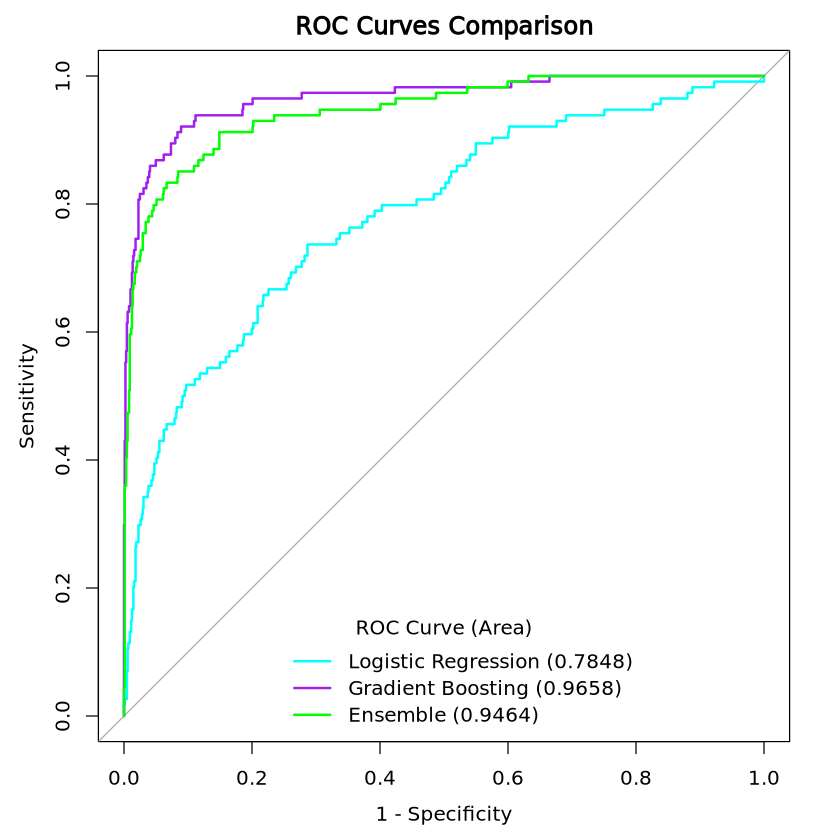

In [15]:
plot(roc_logit, col="cyan", lwd=2, main="ROC Curves Comparison", legacy.axes=TRUE)
lines(roc_gb, col="purple", lwd=2)
lines(roc_ens, col="green", lwd=2)
legend("bottom", title="ROC Curve (Area)",
       legend=c(paste0("Logistic Regression (", round(auc(roc_logit), 4),")"), paste0("Gradient Boosting (", round(auc(roc_gb), 4),")"), paste0("Ensemble (", round(auc(roc_ens), 4),")")),
       col=c("cyan", "purple", "green"),
       lwd=2, 
       bty = "n")


## Model Performance Statistics

Calculate accuracy, sensitivity, and specificity for each model.

In [16]:
best_thresh_logit <- as.numeric(coords(roc_logit, "best", ret="threshold", best.method="youden"))
best_thresh_gb <- as.numeric(coords(roc_gb, "best", ret="threshold", best.method="youden"))
best_thresh_ens <- as.numeric(coords(roc_ens, "best", ret="threshold", best.method="youden"))



true_labels <- y_test

modelPerformance <- function(pred_probs, best_threshold, model_name){
  pred_labels <- ifelse(pred_probs >= best_threshold, 1, 0)
  conf_mat <- table(Predicted = pred_labels, Actual = true_labels)

  TP <- conf_mat["1","1"]
  TN <- conf_mat["0","0"]
  FP <- conf_mat["1","0"]
  FN <- conf_mat["0","1"]

  accuracy <- (TP + TN) / sum(conf_mat)
  sensitivity <- TP / (TP + FN)
  specificity <- TN / (TN + FP)

  metrics <- data.frame(
    Model = model_name,
    Accuracy = accuracy,
    Sensitivity = sensitivity,
    Specificity = specificity,
    TP = TP,
    TN = TN,
    FP = FP,
    FN = FN
  )

  return(metrics)
}

# Now call:
df_logit <- modelPerformance(pred_logit, best_thresh_logit, "Logistic Regression")
df_gb <- modelPerformance(pred_gb,best_thresh_gb, "Gradient Boosting")
df_ens <- modelPerformance(pred_ensemble, best_thresh_ens, "Ensemble")

# Combine all
all_models <- rbind(df_logit, df_gb, df_ens)
print(all_models)

                Model Accuracy Sensitivity Specificity  TP  TN  FP FN
1 Logistic Regression    0.716   0.7368421   0.7133183  84 632 254 30
2   Gradient Boosting    0.912   0.9210526   0.9108352 105 807  79  9
3            Ensemble    0.922   0.8333333   0.9334086  95 827  59 19


## Productionizing the Model

In [18]:
# creating predictions data frame to bind with data
rownames(pred_logit) <- NULL
logit_pred_df <- as.data.frame(pred_logit)
names(logit_pred_df)[1] <- "P_LostCustomer"


In [19]:
# binding testing data and predictions

data_logitpreds <- test_final %>%
  bind_cols(logit_pred_df) %>%   # adds the Preds column
  arrange(desc(P_LostCustomer)) %>%       # sort by Preds descending
  select(ID, customerGender.M, customerGender.F, LostCustomer, P_LostCustomer)

head(data_logitpreds, 20)

,ID,customerGender.M,customerGender.F,LostCustomer,P_LostCustomer
,<int>,<int>,<int>,<int>,<dbl>
1,144729,1,0,1,0.8338663
2,162213,1,0,1,0.7568828
3,177660,0,1,0,0.6997755
4,505,0,1,1,0.6231183
5,143600,1,0,0,0.6096679
6,180307,1,0,0,0.5902768
7,143998,1,0,0,0.5819781
8,11943,0,1,1,0.5749781
9,145383,1,0,1,0.5624855


In [20]:
# creating predictions data frame to bind with data
rownames(pred_gb) <- NULL
gb_pred_df <- as.data.frame(pred_gb)
names(gb_pred_df)[1] <- "P_LostCustomer"


In [22]:
# binding testing data and predictions

data_gbpreds <- test_final %>%
  bind_cols(gb_pred_df) %>%  
  arrange(desc(P_LostCustomer)) %>%   
  select(ID, customerGender.M, customerGender.F, LostCustomer, P_LostCustomer)

head(data_gbpreds, 40)

,ID,customerGender.M,customerGender.F,LostCustomer,P_LostCustomer
,<int>,<int>,<int>,<int>,<dbl>
1,139626,1,0,1,0.9613071
2,64983,0,1,1,0.9593287
3,151547,1,0,1,0.9561270
4,144309,1,0,1,0.9508812
5,144729,1,0,1,0.9416355
6,161763,1,0,1,0.9410781
7,159507,0,1,1,0.9403527
8,156174,1,0,1,0.9350550
9,146695,0,1,1,0.9333385


## Saving the Chamption Model for Deployment

In [23]:
xgb.save(gb_model, "gb_model.model")

[1] TRUE

In [24]:
# Load the model to test it
loaded_xgb <- xgb.load("gb_model.model")


# Create predictions using test data
new_preds <- predict(loaded_xgb, dtest)
head(new_preds)

[1] 0.734514058 0.045541972 0.011725727 0.025740575 0.006039997 0.006283917